In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('../data/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('.save/trfm_origin.pkl'))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('.save/rnnenum_1_7000.pkl'))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# BACE dataset

In [5]:
df = pd.read_csv('data/bace.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(1513, 595)


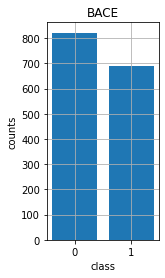

In [6]:
keys = ['0', '1']
bottom = df.groupby('Class').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

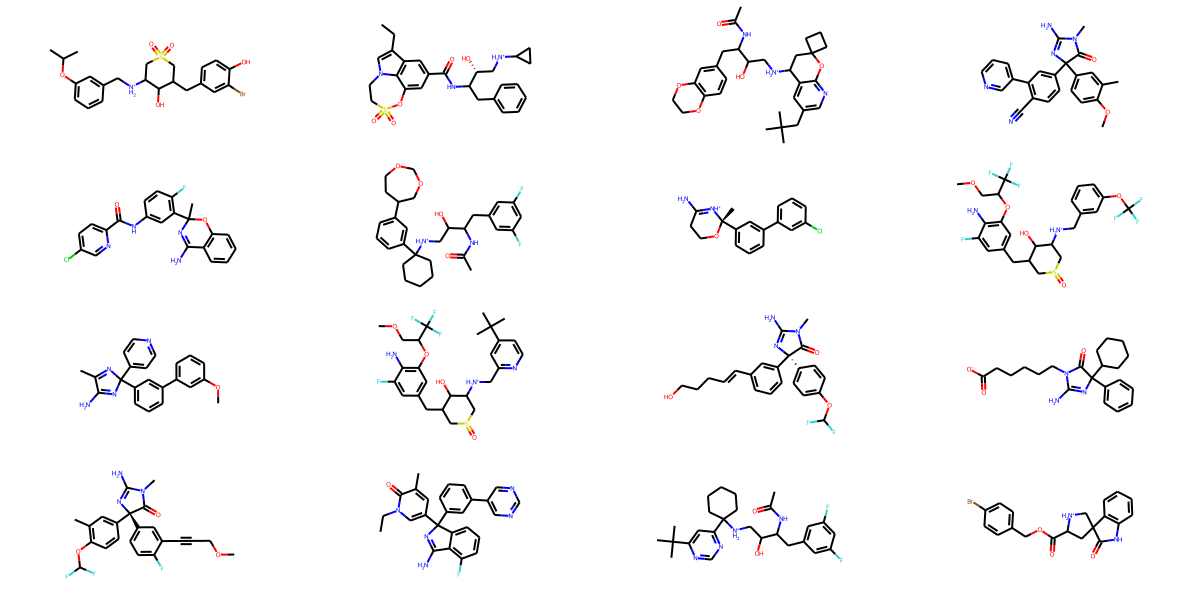

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5892738137310765, 'roc_auc std': 0.05862068841074352, 'prc_auc mean': 0.5364778975431574, 'prc_auc std': 0.05203335861207192}
0.025 {'roc_auc mean': 0.6041131869880195, 'roc_auc std': 0.03674847199651886, 'prc_auc mean': 0.553750386237079, 'prc_auc std': 0.031724176189253085}
0.05 {'roc_auc mean': 0.61712484676984, 'roc_auc std': 0.026600957330204903, 'prc_auc mean': 0.5629119935738949, 'prc_auc std': 0.025164555339150588}
0.1 {'roc_auc mean': 0.6284529525506214, 'roc_auc std': 0.03376291464788819, 'prc_auc mean': 0.5728241572344946, 'prc_auc std': 0.026060197142617644}
0.2 {'roc_auc mean': 0.6555372189274309, 'roc_auc std': 0.01767036354141675, 'prc_auc mean': 0.5994954647404104, 'prc_auc std': 0.016598246598980897}
0.4 {'roc_auc mean': 0.7047215230088713, 'roc_auc std': 0.01646418582778779, 'prc_auc mean': 0.6445086750989776, 'prc_auc std': 0.01544572908668941}
0.8 {'roc_auc mean': 0.7204391743522178, 'roc_auc std': 0.024058227558931253, 'prc_auc mean': 0.66

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6075608641245158, 'roc_auc std': 0.03929613235646862, 'prc_auc mean': 0.5582815108287986, 'prc_auc std': 0.035344892289506415}
0.025 {'roc_auc mean': 0.629365246009605, 'roc_auc std': 0.04144335421191966, 'prc_auc mean': 0.5794287934546327, 'prc_auc std': 0.034806708659029066}
0.05 {'roc_auc mean': 0.6496077892566412, 'roc_auc std': 0.03428030074500289, 'prc_auc mean': 0.5975769666142419, 'prc_auc std': 0.03684858518728505}
0.1 {'roc_auc mean': 0.7014117493699488, 'roc_auc std': 0.014303465557090483, 'prc_auc mean': 0.6522492836125509, 'prc_auc std': 0.019646569191817908}
0.2 {'roc_auc mean': 0.7426906016917945, 'roc_auc std': 0.01583551825306022, 'prc_auc mean': 0.7000253199539922, 'prc_auc std': 0.018508943869903236}
0.4 {'roc_auc mean': 0.7752462181382732, 'roc_auc std': 0.013181216441277784, 'prc_auc mean': 0.7375071580982819, 'prc_auc std': 0.017164425272558178}
0.8 {'roc_auc mean': 0.8099242424242423, 'roc_auc std': 0.02030743519494771, 'prc_auc mean': 0

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5639872087068787, 'roc_auc std': 0.062339807215555966, 'prc_auc mean': 0.5244675278636054, 'prc_auc std': 0.05048210469598828}
0.025 {'roc_auc mean': 0.6081533924831837, 'roc_auc std': 0.04101360059330888, 'prc_auc mean': 0.5591987807204235, 'prc_auc std': 0.03475421553158379}
0.05 {'roc_auc mean': 0.6453155907911841, 'roc_auc std': 0.026042712580482113, 'prc_auc mean': 0.58994458473134, 'prc_auc std': 0.026495717893234683}
0.1 {'roc_auc mean': 0.6772771465195098, 'roc_auc std': 0.022408905077212438, 'prc_auc mean': 0.6200125714769034, 'prc_auc std': 0.023236586334593082}
0.2 {'roc_auc mean': 0.7123959117716572, 'roc_auc std': 0.011181629586693682, 'prc_auc mean': 0.6575997479897595, 'prc_auc std': 0.015923438168818665}
0.4 {'roc_auc mean': 0.7373950976319069, 'roc_auc std': 0.011103554969152662, 'prc_auc mean': 0.6767930628292471, 'prc_auc std': 0.0165628931202891}
0.8 {'roc_auc mean': 0.7719872639437856, 'roc_auc std': 0.030168382871634137, 'prc_auc mean': 0

Classification evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_3384\149481803.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


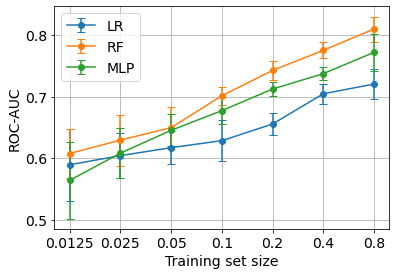

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5869703351628933, 'roc_auc std': 0.05439117843214289, 'prc_auc mean': 0.5377060251095289, 'prc_auc std': 0.04967573569495632}
0.025 {'roc_auc mean': 0.6477800306355772, 'roc_auc std': 0.036950088788976466, 'prc_auc mean': 0.5867589153265167, 'prc_auc std': 0.03807573247261548}
0.05 {'roc_auc mean': 0.6915804777467907, 'roc_auc std': 0.03986686653871713, 'prc_auc mean': 0.6335082071844981, 'prc_auc std': 0.04439091489744989}
0.1 {'roc_auc mean': 0.722269053619536, 'roc_auc std': 0.023551794181408195, 'prc_auc mean': 0.6590265235416028, 'prc_auc std': 0.024796818672325062}
0.2 {'roc_auc mean': 0.7698483541005953, 'roc_auc std': 0.010873693995079167, 'prc_auc mean': 0.712288535833394, 'prc_auc std': 0.014617658648103576}
0.4 {'roc_auc mean': 0.8054595664605684, 'roc_auc std': 0.014088941647411429, 'prc_auc mean': 0.7553036420747545, 'prc_auc std': 0.0223057473779069}
0.8 {'roc_auc mean': 0.8266073781291172, 'roc_auc std': 0.024912368941236135, 'prc_auc mean': 0.7

ST + Random Forest Classifier

In [14]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.5702930601735318, 'roc_auc std': 0.045596213948039366, 'prc_auc mean': 0.5300629247158419, 'prc_auc std': 0.042358655871993695}
0.025 {'roc_auc mean': 0.5937408888757335, 'roc_auc std': 0.030699470495640657, 'prc_auc mean': 0.5456119752081178, 'prc_auc std': 0.028760993506616095}
0.05 {'roc_auc mean': 0.6243674931838157, 'roc_auc std': 0.022777219726124134, 'prc_auc mean': 0.5798131412139199, 'prc_auc std': 0.02588974072956181}
0.1 {'roc_auc mean': 0.6727531068045538, 'roc_auc std': 0.024125378132889595, 'prc_auc mean': 0.6268084381895404, 'prc_auc std': 0.02673193599133118}
0.2 {'roc_auc mean': 0.7175079148276602, 'roc_auc std': 0.021217175384741986, 'prc_auc mean': 0.6754566915424542, 'prc_auc std': 0.023683938233035145}
0.4 {'roc_auc mean': 0.7631825069038832, 'roc_auc std': 0.01125136235871144, 'prc_auc mean': 0.7210594285443227, 'prc_auc std': 0.01419010633783701}
0.8 {'roc_auc mean': 0.8125845410628019, 'roc_auc std': 0.020646494217753195, 'prc_auc mean'

ST + Multi-layer Perceptron Classifier (MLP)

In [15]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5958435059033963, 'roc_auc std': 0.056161752794935155, 'prc_auc mean': 0.5454621823541985, 'prc_auc std': 0.05549508734435773}
0.025 {'roc_auc mean': 0.6267380972642578, 'roc_auc std': 0.040108229377616066, 'prc_auc mean': 0.5783088776718212, 'prc_auc std': 0.042348739131919354}
0.05 {'roc_auc mean': 0.6808256693892425, 'roc_auc std': 0.03214599638044792, 'prc_auc mean': 0.6264467852490658, 'prc_auc std': 0.03780411090541698}
0.1 {'roc_auc mean': 0.737062874771878, 'roc_auc std': 0.019124686287499873, 'prc_auc mean': 0.6803164088727172, 'prc_auc std': 0.023401015806267866}
0.2 {'roc_auc mean': 0.7718878650302028, 'roc_auc std': 0.010639492541667038, 'prc_auc mean': 0.7241642839219697, 'prc_auc std': 0.01762630194789784}
0.4 {'roc_auc mean': 0.7960651531073584, 'roc_auc std': 0.014158624653439067, 'prc_auc mean': 0.7455963005561891, 'prc_auc std': 0.01972862345824586}
0.8 {'roc_auc mean': 0.8488603425559947, 'roc_auc std': 0.021913688899965922, 'prc_auc mean': 

SMILES TRANSFORMER evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_3384\56411120.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


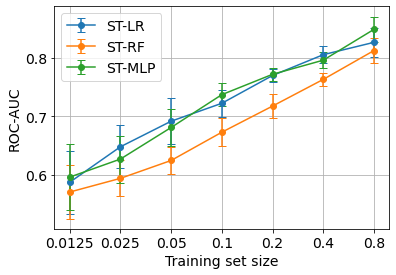

In [16]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training RNN model

In [17]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


RNN + Logistic Regression

In [18]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5401752807449026, 'roc_auc std': 0.03272985295615075, 'prc_auc mean': 0.4848190386157839, 'prc_auc std': 0.034071958690882004}
0.025 {'roc_auc mean': 0.5938498523720372, 'roc_auc std': 0.038164369051617256, 'prc_auc mean': 0.5321458408549032, 'prc_auc std': 0.038987183816723996}
0.05 {'roc_auc mean': 0.6356887415540704, 'roc_auc std': 0.029874499320511352, 'prc_auc mean': 0.5639048194948584, 'prc_auc std': 0.03703513822444019}
0.1 {'roc_auc mean': 0.6895261579907882, 'roc_auc std': 0.017247790617810704, 'prc_auc mean': 0.6216992308727349, 'prc_auc std': 0.02466449849836332}
0.2 {'roc_auc mean': 0.7309120739596672, 'roc_auc std': 0.014552714782177055, 'prc_auc mean': 0.6764081225688167, 'prc_auc std': 0.022098358006349513}
0.4 {'roc_auc mean': 0.7684862777682738, 'roc_auc std': 0.011565541287438074, 'prc_auc mean': 0.718506108484254, 'prc_auc std': 0.01747737024932049}
0.8 {'roc_auc mean': 0.8013899868247693, 'roc_auc std': 0.02283312301264886, 'prc_auc mean': 

RNN + Random Forest Classifier

In [19]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

0.0125 {'roc_auc mean': 0.5723877381012484, 'roc_auc std': 0.043890341225192336, 'prc_auc mean': 0.5285856080813274, 'prc_auc std': 0.037506328716522916}
0.025 {'roc_auc mean': 0.6047253435402592, 'roc_auc std': 0.036781983953053564, 'prc_auc mean': 0.5624087141315991, 'prc_auc std': 0.033540073034491164}
0.05 {'roc_auc mean': 0.6786929686601691, 'roc_auc std': 0.02169264960027119, 'prc_auc mean': 0.6334622951019193, 'prc_auc std': 0.032684828504782285}
0.1 {'roc_auc mean': 0.7074409598505257, 'roc_auc std': 0.022466152363547046, 'prc_auc mean': 0.6716327848354802, 'prc_auc std': 0.029293054902149594}
0.2 {'roc_auc mean': 0.7773349428648377, 'roc_auc std': 0.011731586892301759, 'prc_auc mean': 0.7417636045112562, 'prc_auc std': 0.01450966576595426}
0.4 {'roc_auc mean': 0.8175936606466434, 'roc_auc std': 0.013589454754521835, 'prc_auc mean': 0.7839721799308732, 'prc_auc std': 0.0167891541366014}
0.8 {'roc_auc mean': 0.8501383399209486, 'roc_auc std': 0.026617370848985026, 'prc_auc mean'

RNN + Multi-layer Perceptron Classifier (MLP)

In [23]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.565288020468954, 'roc_auc std': 0.03778893486509729, 'prc_auc mean': 0.5023924056694213, 'prc_auc std': 0.03573041167196063}
0.025 {'roc_auc mean': 0.5813886555865528, 'roc_auc std': 0.04571476033050842, 'prc_auc mean': 0.5220772839741414, 'prc_auc std': 0.03725829001796418}
0.05 {'roc_auc mean': 0.62532775176032, 'roc_auc std': 0.03670420022369718, 'prc_auc mean': 0.5626076905355657, 'prc_auc std': 0.039268032884796356}
0.1 {'roc_auc mean': 0.6775778330581386, 'roc_auc std': 0.01290884160231805, 'prc_auc mean': 0.603617821995083, 'prc_auc std': 0.018672063951375984}
0.2 {'roc_auc mean': 0.7340707222829881, 'roc_auc std': 0.021219075894914296, 'prc_auc mean': 0.6807812799867408, 'prc_auc std': 0.02129587580961601}
0.4 {'roc_auc mean': 0.6689490212370781, 'roc_auc std': 0.01635931804750641, 'prc_auc mean': 0.6119335641455651, 'prc_auc std': 0.02306596081639268}
0.8 {'roc_auc mean': 0.757342995169082, 'roc_auc std': 0.024078865213381095, 'prc_auc mean': 0.720853

# Pre-training RNN Evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_3384\1491995531.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


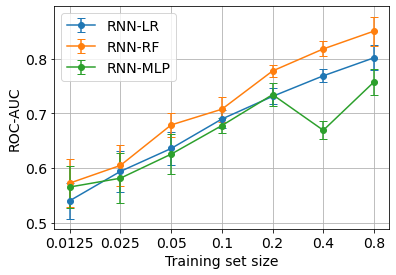

In [24]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Classification evaluation with Pre-training Smiles Transformer, RNN and without pre-training

C:\Users\anhtt\AppData\Local\Temp\ipykernel_3384\766386080.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


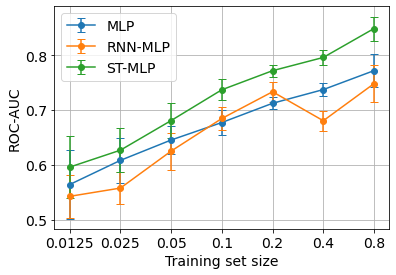

In [22]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Visualization of the Latent Space

In [26]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X_sf)

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [27]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

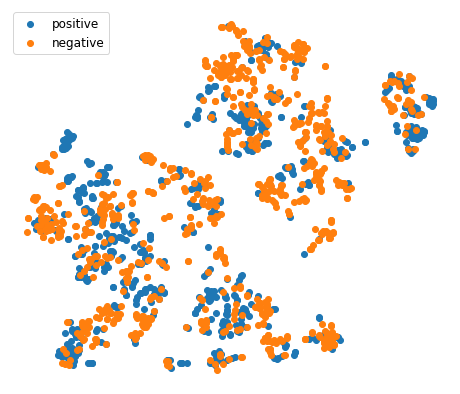

In [30]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['Class']==1][:,0], X_reduced[df['Class']==1][:,1], label='positive', marker='o')
plt.scatter(X_reduced[df['Class']==0][:,0], X_reduced[df['Class']==0][:,1], label='negative', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('bbbp.png', dpi=300)
plt.show()